<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/beehive_audio_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get processed data

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")
# move zip file to colab vm
! cp -r gdrive/My\ Drive/5230Project/processed_data ./

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 114, done.
Receiving objects: 100% (114/114), 56.94 KiB | 2.85 MiB/s, done.
remote: Total 114 (delta 0), reused 0 (delta 0), pack-reused 114
Resolving deltas: 100% (56/56), done.


In [ ]:
! pip install muda

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, mir_eval, IPython.display, urllib


In [34]:
block_size = 5
path_workingFolder = '/content/processed_data/dataset_BeeNoBee_'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json') 

In [35]:
get_features_from_samples

<function utils.get_features_from_samples>

In [37]:
def get_features_from_samples(path_audio_samples, sample_ids, raw_feature, normalization, high_level_features ): #normalization = NO, z_norm, min_max
    ## function to extract features 
    #high_level_features = 0 or 1 
    
    n_samples_set = len(sample_ids) # 4
    feature_Maps = []
    
    for sample in sample_ids:
        
        # raw feature extraction:
        x = raw_feature_fromSample( path_audio_samples+sample, raw_feature ) # x.shape: (4, 20, 2584)
        
        
        ##normalization here:
        if not normalization == 'NO':
          x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
        else: 
          x_norm = x
        
        if high_level_features:
            # high level feature extraction:
            if 'MFCCs' in raw_feature:
              #x_norm = featureMap_normalization_block_level(x, normalizationType = normalization) 
                X = compute_statistics_overMFCCs(x_norm, 'yes') # X.shape: (4 , 120)
            else: 
                X = compute_statistics_overSpectogram(x_norm)
                
            feature_map=X
        else:
            feature_map=x_norm
        
        
        feature_Maps.append(feature_map)
        
    return feature_Maps

In [38]:
X_train = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'NO', 1)
X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)
    

In [49]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train= labels2binary('nobee', labels_train)
    
labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
Y_val= labels2binary('nobee', labels_val)
    
labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
Y_test= labels2binary('nobee', labels_test)

## pca

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [53]:
len(X_train)

241

In [50]:
pca = PCA(n_components = 2)

pca = PCA(n_components = 2).fit_transform(X_train)

pca_df = pd.DataFrame(data = pca, columns = ['component1', 'component2'])

pca_df = pd.concat([pca_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)

## K-means

In [54]:
model = sklearn.cluster.KMeans(n_clusters=2)
labels_pca = model.fit_predict(pca)
labels_pca

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [79]:
labels = model.fit_predict(X_train)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [85]:
pred_km = pd.concat([pca_df, pd.DataFrame(list(labels), columns = ['predicted_label'])],axis=1)

plot results 

Text(0.5, 1.0, 'prediction with K-means')

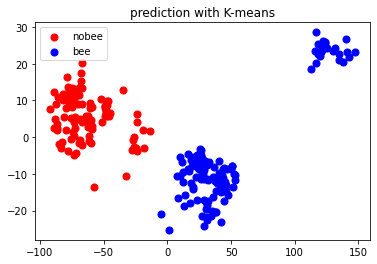

In [89]:

plt.scatter(pred_km[pred_km['predicted_label']==0].iloc[:,0], pred_km[pred_km['predicted_label']==0].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pred_km[pred_km['predicted_label']==1].iloc[:,0], pred_km[pred_km['predicted_label']==1].iloc[:,1], c='b', s=50, cmap='viridis')

plt.legend(('nobee', 'bee'))
plt.title("prediction with K-means")

Text(0.5, 1.0, 'True label')

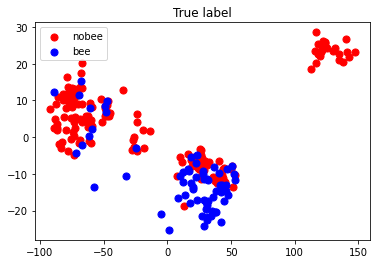

In [90]:
plt.scatter(pred_km[pred_km['label']==0].iloc[:,0], pred_km[pred_km['label']==0].iloc[:,1], c='r', s=50, cmap='viridis')
plt.scatter(pred_km[pred_km['label']==1].iloc[:,0], pred_km[pred_km['label']==1].iloc[:,1], c='b', s=50, cmap='viridis')

plt.legend(('nobee', 'bee'))
plt.title("True label")